# KUR for counting observables

Here we will study the example given by Juan P Garrahan on fluctuations in counting observables. The idea is quite simple. Suppose we have some classical jump process where we have some counting observable $A$ (i.e particle current). We also have an associate dynamical activity with this quantity $K_{A}$. We can also define the time (which is a random variable) for which this stochastic process takes to hit the value $A$, which we will denote $\tau_{A}$. What Garrahan shows, is that the signal to noise ratio of the First hitting time (FHT) of the counting observable $A$ is given by 
$$
\frac{{\rm E} [\tau_{A}]^{2}}{{\rm Var}[\tau_{A}]} \leq {\rm E}[\tau_{A}] K_{A}
$$
Those familiar with Tan Van Vu's paper on the similar topic will immediately recognise the similarities between the two. The main difference is that in Garrahan's paper, the counting observable is for a classical, whereas in Tan Van Vu's paper is for a quantum system.

He we will model the classcial process via the classical rate equation
$$
\frac{d\rho_{t}}{dt} = \gamma_{+}\mathcal{D}[c^{\dagger}]\rho + \gamma_{-}\mathcal{D}[c]\rho
$$
which we can make quantum mechanical by adding a Rabi drive along $\sigma_{x}$ direction 
$$
\frac{d\rho_{t}}{dt} = -i[\Omega \sigma_{x}, \rho] + \gamma_{+}\mathcal{D}[c^{\dagger}]\rho + \gamma_{-}\mathcal{D}[c]\rho 
$$
We expect Garrahan's inequality to be violated in this case but satisified in the former. Tan Van Vu's should offer the correct bound in both cases. Here $\gamma_{+} = \gamma (n + 1)$ and $\gamma_{-} = \gamma n$.

We can compute the dynamical activity using 
$$
K_{A} = \sum_{i=1}^{2}{\rm tr}[L_{k}^{\dagger}L_{k}\rho_{ss}] = \frac{2 \gamma  (2 n+1) \left(\gamma ^2 n (n+1)+2 \Omega ^2\right)}{(\gamma +2 \gamma  n)^2+8 \Omega ^2}
$$
where $\rho_{ss}$ is the steadystate.
Van Vu's inequality is a modification of Garrahans inequality. It is given by
$$
\frac{{\rm E}[\tau_{A}]^{2}}{{\rm Var}[\tau_{A}]} \leq {\rm E}[\tau_{A}] \left(K_{A} + \mathcal{Q}\right)
$$
where 
$$
\mathcal{Q} = -4\left( \bra{I} \mathcal{K}_{1}\mathcal{L}^{+}\mathcal{K}_{2}\ket{\rho_{ss}} + \bra{I} \mathcal{K}_{2}\mathcal{L}^{+}\mathcal{K}_{1}\ket{\rho_{ss}}\right) = \frac{64 \Omega ^2 \left(\gamma ^2 n (n+1)+2 \Omega ^2\right)}{8 \gamma  (2 n+1) \Omega ^2+(\gamma +2 \gamma  n)^3}\,.
$$
Clearly when $\Omega=0$ we recover Garrahan's inequality.

In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None
    

def dynamical_activity(n, gamma, omega):
    numerator = 2 * (1 + 2 * n) * gamma * (n * (1 + n) * gamma**2 + 2 * omega**2)
    denominator = ((gamma + 2 * n * gamma)**2 + 8 * omega**2)
    return numerator / denominator

def quantum_dynamical_activity(n, gamma, Omega):
    numerator = 64 * Omega**2 * (gamma**2 * n * (n+1) + 2 * Omega**2)
    denominator = 8 * gamma * (2*n+1) * Omega**2 + (gamma + 2*gamma*n)**3
    return numerator / denominator


In [2]:
# Parameters
gamma = 1
nbar = 0.2
Omega = 0.5
dt = 0.0005
dts = 0.01
tf = 30
t = np.arange(0, tf, dt)
ts = np.arange(0, tf, dts)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [np.sqrt(gamma * (1+nbar)) * sm, np.sqrt(gamma * nbar) * sp]    
H_eff = H - 0.5j * sum([c_op.dag() * c_op for c_op in c_ops])

# steadystate
rho_ss = steadystate(H, c_ops)

# Compute dynamical activity per unity time
K = sum([expect(c_op.dag() * c_op, rho_ss) for c_op in c_ops])
Q = quantum_dynamical_activity(nbar, gamma, Omega)

In [3]:
# number of chargers to truncate at 
Nm = 50
dN = 1
N_cutoff = 5
N = np.arange(-10, Nm, dN)
# Compute initial state
rho0 = operator_to_vector(steadystate(H, c_ops))
nu_k = [0, -1, 0]

#----------------- Solve -----------------#
proj = ProjectiveEvolutionPntAbsorb(H_eff, c_ops, t, N, N_cutoff-1)
Pn_vec = proj.solve(rho0, nu_k)

# Compute survival probability
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 59999/59999 [00:02<00:00, 28446.71it/s]


In [4]:
# qutip evolution
result = photocurrent_mesolve(H, rho_ss, ts, sc_ops=c_ops, e_ops=[sz], store_measurement=True, ntraj=1000)

10.0%. Run time:   1.13s. Est. time left: 00:00:00:10
20.0%. Run time:   2.24s. Est. time left: 00:00:00:08
30.0%. Run time:   3.40s. Est. time left: 00:00:00:07
40.0%. Run time:   4.54s. Est. time left: 00:00:00:06
50.0%. Run time:   5.71s. Est. time left: 00:00:00:05
60.0%. Run time:   6.89s. Est. time left: 00:00:00:04
70.0%. Run time:   8.04s. Est. time left: 00:00:00:03
80.0%. Run time:   9.20s. Est. time left: 00:00:00:02
90.0%. Run time:  10.34s. Est. time left: 00:00:00:01
Total run time:  11.55s


In [5]:
# Get measurement trajectories
dNm = np.real(np.array(result.measurement)[:, :, 0])*dts
dNp = np.real(np.array(result.measurement)[:, :, 1])*dts

# Compute photocurrent
J = np.cumsum(dNm, axis=1)

In [6]:
# Get first hitting times
inds = np.array([get_first_hit(mi, N_cutoff) for mi in J])
inds = inds[inds != None]

# Get first hitting times
hitting_times = ts[list(inds)]

In [7]:
# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2 )*dt - Et**2

SNR = Et**2 / Var

print(SNR/(Et*K), 1)
print(SNR/(Et*(K+Q)), 1)

1.6888978624624562 1
0.33235339462112573 1


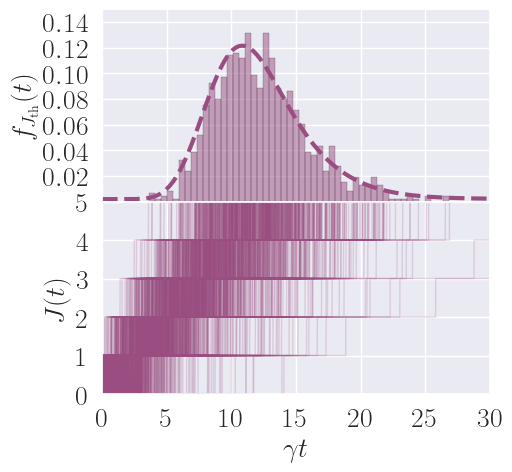

In [21]:
#----------------- Plotting -----------------#

fig = plt.figure(figsize=(5, 5))

color = [0.6, 0.3, 0.5]

plt.subplot(2, 1, 1)
plt.plot(t, dGt+0.002, color=color, linestyle='--', linewidth=3, alpha=1)
plt.hist(hitting_times, density=True, bins=50, color=color, alpha=0.5, edgecolor='k', linewidth=0.3)
# plt.vlines(Et, 0, dGt[np.argmin(np.abs(t-Et))], color='k', linestyle='--', linewidth=2, alpha=1)

plt.xticks(np.arange(0, tf+5, 5), [], fontsize=20)
plt.yticks(np.arange(0.02, 0.16, 0.02), fontsize=20)
plt.ylim(0.0, 0.15)
plt.xlim(0, tf)
plt.ylabel(r"$f_{J_{\rm th}}(t)$", fontsize=20)


plt.subplot(2, 1, 2)
plt.plot(ts, J.T, color=color, linestyle='-', linewidth=1, alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(np.arange(0, tf+5, 5), fontsize=20)
plt.ylim(0, N_cutoff)
plt.xlim(0, tf)

plt.xlabel(r'$\gamma t$', fontsize=20)
plt.ylabel(r'$J(t)$', fontsize=20)

plt.subplots_adjust(hspace=0.0)

plt.show()

#----------------- Save -----------------#
fig.savefig('Figures/Garrahan_example.png', bbox_inches='tight', dpi=200)

# Repeat analysis but loop over different values of $\bar{n}$ and $\Omega$ creating a surface plot of the SNR

In [11]:
saved_data = True

if saved_data:
    # load data
    import pickle 
    # load the dictionary
    with open('Data/data.pickle', 'rb') as handle:
        data = pickle.load(handle)

    # upack data
    Et_vals = data['Et_vals']
    Var_vals = data['Var_vals']
    SNR_vals = data['SNR_vals']
    K_vals = data['K_vals']
    Q_vals = data['Q_vals']
    nbars = data['nbar']
    Omegas = data['Omega']

else:
    # parameters
    nbars = [0.1, 0.5, 1]
    Omegas = np.linspace(0.0, 2, 100)
    gamma = 1

    # time parameters
    dt = 0.00025
    tf = 100
    t = np.arange(0, tf, dt)

    # Define system operators
    sp = sigmap()
    sm = sigmam()
    sx = sigmax()
    sz = sigmaz()

    # counting params
    nu_k = [0, -1, 0]
    # number of chargers to truncate at 
    Nm = 50
    dN = 1
    N_cutoff = 5
    N = np.arange(-10, Nm, dN)

    # initialise matrices
    Et_vals = np.zeros((len(nbars), len(Omegas)))
    Var_vals = np.zeros((len(nbars), len(Omegas)))
    SNR_vals = np.zeros((len(nbars), len(Omegas)))
    K_vals = np.zeros((len(nbars), len(Omegas)))
    Q_vals = np.zeros((len(nbars), len(Omegas)))

    count = 1

    for i, nbar in enumerate(nbars):
        for j, Omega in enumerate(Omegas):
            
            print('nbar = ', nbar, 'Omega = ', Omega)
            print(count, 'out of', len(nbars)*len(Omegas), 'iterations')
            count += 1
            
            # Define Hamiltonian
            H = Omega*sx

            # define dissipator and Hamiltonian
            c_ops = [np.sqrt(gamma * (1+nbar)) * sm, np.sqrt(gamma * nbar) * sp]    
            H_eff = H - 0.5j * sum([c_op.dag() * c_op for c_op in c_ops])

            # steadystate
            rho_ss = steadystate(H, c_ops)

            # Compute dynamical activity per unity time
            K_vals[i, j] = sum([expect(c_op.dag() * c_op, rho_ss) for c_op in c_ops])
            Q_vals[i, j] = quantum_dynamical_activity(nbar, gamma, Omega)

            # Compute initial state
            rho0 = operator_to_vector(steadystate(H, c_ops))

            #----------------- Solve -----------------#
            proj = ProjectiveEvolutionPntAbsorb(H_eff, c_ops, t, N, N_cutoff-1)
            Pn_vec = proj.solve(rho0, nu_k)

            # Compute survival probability
            P0 = np.sum(Pn_vec, axis=0)
            dGt = -np.gradient(P0, dt)

            # Compute mean and variance of distribution
            Et = np.sum(dGt * t)*dt
            Var = np.sum(dGt * t**2 )*dt - Et**2

            SNR = Et**2 / Var

            # Compute mean and variance of distribution
            Et_vals[i, j] = Et
            Var_vals[i, j] = Var

            SNR_vals[i, j] =SNR

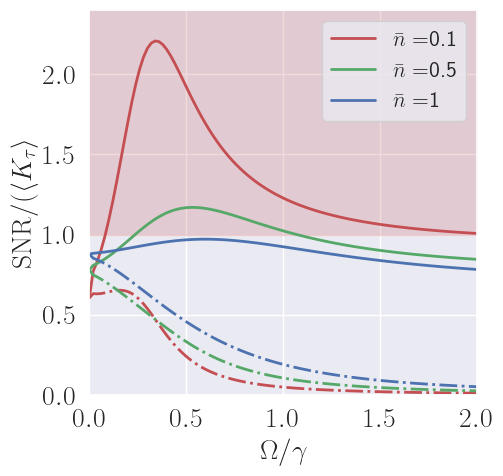

In [22]:
# compute both inequalitys
ineq1 = SNR_vals / (Et_vals*K_vals)
ineq2 = SNR_vals / (Et_vals*(K_vals+Q_vals))

# plot as a function of Omega
fig = plt.figure(figsize=(5, 5))



colors = ['r', 'g', 'b']

for i, nbar in enumerate(nbars):
    plt.plot(Omegas, ineq1[i], '-', color=colors[i], label=r'$\bar{n} = $'+str(nbar), linewidth=2)
    plt.plot(Omegas, ineq2[i], '-.', color=colors[i], linewidth=2)

# plt.hlines(1, 0, Omegas[-1], color='k', linestyle='--', linewidth=2, alpha=1)
plt.fill_betweenx([1, 3], 0, Omegas[-1], color='r', alpha=0.2)
plt.xlim(0, Omegas[-1])
plt.ylim(0, 2.4)

plt.yticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xlabel(r'$\Omega/\gamma$', fontsize=20)
plt.ylabel(r'${\rm SNR}/(\langle K_{\tau} \rangle $', fontsize=20)

plt.legend(fontsize=16)

plt.show()

fig.savefig('Figures/inequality.png', bbox_inches='tight', dpi=200)

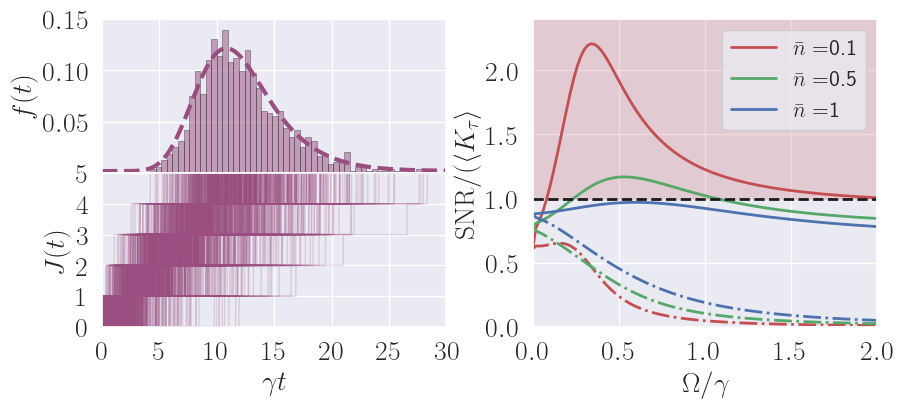

In [81]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(t, dGt+0.002, color=color, linestyle='--', linewidth=3, alpha=1)
ax1.hist(hitting_times, density=True, bins=50, color=color, alpha=0.5, edgecolor='k', linewidth=0.5)

plt.xticks(np.arange(0, tf+5, 5), [], fontsize=20)
plt.yticks(np.arange(0.05, 0.2, 0.05), fontsize=20)
ax1.set_ylim(0.0, 0.15)
ax1.set_xlim(0, tf)
ax1.set_ylabel(r'$f(t)$', fontsize=20)

ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(ts, J.T, color=color, linestyle='-', linewidth=1, alpha=0.2)

# ax2.set_xticks(np.arange(0, tf+5, 5))
ax2.set_yticks(np.arange(0, N_cutoff+1, 1))
plt.xticks(np.arange(0, tf+5, 5), fontsize=20)
plt.yticks(np.arange(0, N_cutoff+1, 1), fontsize=20)
ax2.set_ylim(0.0, N_cutoff)
ax2.set_xlim(0, tf)
ax2.set_ylabel(r'$J(t)$', fontsize=20)
ax2.set_xlabel(r'$\gamma t$', fontsize=20)

ax3 = fig.add_subplot(gs[:, 1])

colors = ['r', 'g', 'b']

for i, nbar in enumerate(nbars):
    ax3.plot(Omegas, ineq1[i], '-', color=colors[i], label=r'$\bar{n} = $'+str(nbar), linewidth=2)
    ax3.plot(Omegas, ineq2[i], '-.', color=colors[i], linewidth=2)

ax3.hlines(1, 0, Omegas[-1], color='k', linestyle='--', linewidth=2, alpha=1)
plt.fill_betweenx([1, 3], 0, Omegas[-1], color='r', alpha=0.2)
plt.xlim(0, Omegas[-1])
plt.ylim(0, 2.4)

plt.yticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xticks(np.arange(0, 2.5, 0.5), fontsize=20)
plt.xlabel(r'$\Omega/\gamma$', fontsize=20)
plt.ylabel(r'${\rm SNR}/(\langle K_{\tau} \rangle $', fontsize=20)
plt.legend(fontsize=16)

plt.subplots_adjust(wspace=0.25, hspace=0)

plt.show()

fig.savefig('Figures/Garrahan.png', bbox_inches='tight', dpi=200)
